# Water uptake by a single root

*by Andrea Schnepf


1D radially symmetric problem. Scenarios according to Schröder et al. 2008. 
Water flow in soil is described by the Richards equation 

## Benchmarks for the 1D radially symmetric problem

Schröder et al. (2008).  

In the following benchmarks soil properties are described by the van Genuchten model (Van Genuchten, 1980). In the following we first import libraries and define some auxiliary functions:

In [10]:
import numpy as np
from scipy import optimize
from scipy import integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from math import * 
import os

In [19]:
# Mualem - van Genuchten model, equations from van Genuchten, MT (1980)

# class containing the van genuchten parameters
class Parameters:
    def __init__(self, R, S, alpha, n, Ksat):
        self.theta_R = R
        self.theta_S = S        
        self.alpha = alpha # [1/cm]         
        self.n = n
        self.m = 1.-1./n
        self.Ksat = Ksat       

# returns the volumetric water content at a given pressure head  according to the van genuchten model (Eqn 21)
def water_content(h, sp):
    return sp.theta_R + (sp.theta_S-sp.theta_R)/pow(1. + pow(sp.alpha*abs(h),sp.n),sp.m)

# returns pressure head at a given volumetric water content according to the van genuchten model
def pressure_head(theta, sp): 
    theta = min(theta,sp.theta_S) # saturated water conent is the maximum 
    return - pow( pow( (sp.theta_S - sp.theta_R)/(theta - sp.theta_R), (1./sp.m))-1., 1./sp.n) / sp.alpha

# returns the effective saturation according to the van genuchten model (dimensionless water content, Eqn 2)
def effective_saturation(h,sp):
    h = min(h,0) # pressure head is negative, zero the maximum
    theta = water_content(h,sp)
    se = (theta-sp.theta_R)/(sp.theta_S-sp.theta_R)
    return se

# returns the hydraulic conductivity according to the van genuchten model (Eqn 8)
def hydraulic_conductivity(h,sp):
    se = effective_saturation(h,sp) 
    K = sp.Ksat*sqrt(se)*( (1. - pow(1. - pow(se, 1. / sp.m),sp.m)) ** 2 )
    return K 

# returns the specific moisture storage according to the van genuchten model
def specific_moisture_storage(h,sp):
    C = -sp.alpha*sp.n*np.sign(h)*(1. / sp.n - 1.) * pow(sp.alpha*abs(h), sp.n-1.) * (sp.theta_R-sp.theta_S) * pow(pow(sp.alpha*abs(h),sp.n) + 1., 1./sp.n-2.)
    return C

# returns the water diffusivity (Eqn 11)
def water_diffusivity(TH, theta_i, theta_sur, sp):
    theta = TH * (theta_i - theta_sur) + theta_sur
    Se = (theta - sp.theta_R) / (sp.theta_S - sp.theta_R)
    m = sp.m
    D = (1 - m) * sp.Ksat / (sp.alpha * m * (sp.theta_S - sp.theta_R)) * pow(Se, 0.5 - 1. / m) * (pow(1 - pow(Se, 1. / m), -m) + pow(1 - pow(Se, 1 / m), m) - 2)
    return D

# returns the matric flux potential
def MFP(h,sp):
    K = lambda h: hydraulic_conductivity(h,sp) # integrand 
    MFP, err = integrate.quad(K,-15000, h)
    return MFP

# returns the matric potential from matric flux potential
def h(MFP_given,sp):
    MFP_root = lambda psi: MFP(psi,sp)-MFP_given
    h = optimize.brentq(MFP_root, -15000, 0)
    return h

The benchmarks use the following soil types (from the soil catalogue of Hydrus 1D), the parameters are $\theta_r$, $\theta_s$, $\alpha$, $n$, and $K_s$:

In [30]:
sand = Parameters(0.02, 0.46, 0.0144, 1.534, 15.42) 
loam = Parameters(0.01, 0.42, 0.0084, 1.441, 12.98)
clay = Parameters(0.01, 0.59, 0.0195, 1.109, 4.53)

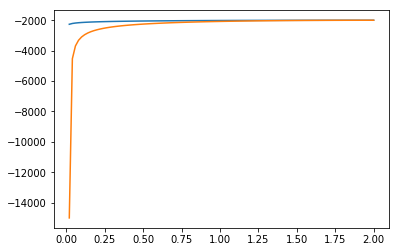

In [59]:
r_root = 0.02   # cm
r_out = 2        #cm
rho = r_out/r_root
q_root = 0.5;  # [cm/d]
h_out = -2000;   #cm
h_lim = -15000   # cm
q_out = 0#q_root * (r_root/(2*r_out))


r = np.linspace(r_root, r_out, 100)
MFP_nostress = MFP(h_out,loam) + (q_root*r_root-q_out*r_out)*(r**2/r_root**2/(2*(1-rho**2))+rho**2/(1-rho**2)*(np.log(r_out/r)-0.5)) + q_out*r_out*np.log(r/r_out)
MFP_stress  = (MFP(h_out,loam)+q_out*r_out*np.log(1/rho))*( (r**2/r_root**2 - 1 + 2*rho**2*np.log(r_root/r))/(rho**2 - 1+2*rho**2*np.log(1/rho)) ) + q_out*r_out*np.log(r/r_root)
h_nostress = np.zeros(len(r)); h_stress = np.zeros(len(r))
for i in range(len(r)):
    h_nostress[i] = h(MFP_nostress[i],loam)
    h_stress[i] = h(MFP_stress[i],loam)
# plots
plt.plot(r,h_nostress)
plt.plot(r,h_stress)
plt.show()